In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from post_processing import *
from utils_mini import *
from fast_macro_f1_func import *
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

In [3]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"

print(df_train.shape, df_test.shape)
df_train.head()

(4500000, 6) (2000000, 6)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1,1
1,0.0002,-2.8557,0,0.0002,1,1
2,0.0003,-2.4074,0,0.0003,1,1
3,0.0004,-3.1404,0,0.0004,1,1
4,0.0005,-3.1525,0,0.0005,1,1


In [4]:
BATCH_GROUP = [6]
TEST_GROUP = [9]

signal = df_train[df_train.batch.isin(BATCH_GROUP)]['signal'].values
signal_test = df_train[df_train.batch.isin(TEST_GROUP)]['signal'].values

true_state = df_train[df_train.batch.isin(BATCH_GROUP)]['open_channels'].values
true_state_test= df_train[df_train.batch.isin(TEST_GROUP)]['open_channels'].values

In [5]:
def viterbi(p_trans, p_signal, p_in, signal):

    offset = 10**(-20) # added to values to avoid problems with log2(0)

    p_trans_tlog  = np.transpose(np.log2(p_trans  + offset)) # p_trans, logarithm + transposed
    p_signal_tlog = np.transpose(np.log2(p_signal + offset)) # p_signal, logarithm + transposed
    p_in_log      =              np.log2(p_in     + offset)  # p_in, logarithm

    p_state_log = [ p_in_log + p_signal_tlog[signal[0]] ] # initial state probabilities for signal element 0 

    for s in signal[1:]:
        p_state_log.append(np.max(p_state_log[-1] + p_trans_tlog, axis=1) + p_signal_tlog[s]) # the Viterbi algorithm

    states = np.argmax(p_state_log, axis=1) # finding the most probable states
    
    return np.array(p_state_log), states

In [6]:
def calc_markov_p_trans(states):
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # if a state doesn't appear in states...
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
        else:
            current_row = current_row / np.sum(current_row) # normalize to 1
        matrix.append(current_row)
    return np.array(matrix)

p_trans = calc_markov_p_trans(true_state)

(6.0, 0.0)

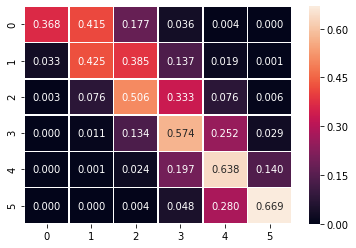

In [7]:
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(p_trans, annot=True, fmt=".3f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [8]:
def calc_markov_p_signal(state, signal, num_bins = 1000):
    states_range = np.arange(state.min(), state.max() + 1)
    signal_bins = np.linspace(signal.min(), signal.max(), num_bins + 1)
    p_signal = np.array([ np.histogram(signal[state == s], bins=signal_bins)[0] for s in states_range ])
    p_signal = np.array([ p / np.sum(p) for p in p_signal ]) # normalize to 1
    return p_signal, signal_bins

p_signal, signal_bins = calc_markov_p_signal(true_state, signal)

In [9]:
def digitize_signal(signal, signal_bins):
    signal_dig = np.digitize(signal, bins=signal_bins) - 1 # these -1 and -2 are necessary because of the way...
    signal_dig = np.minimum(signal_dig, len(signal_bins) - 2) # ... numpy.digitize works
    return signal_dig

signal_dig = digitize_signal(signal, signal_bins)
signal_dig_test = digitize_signal(signal_test, signal_bins)
print ("Signal bin values:", signal_dig)

Signal bin values: [774 802 853 ... 862 833 839]


In [10]:
p_in = np.ones(len(p_trans)) / len(p_trans)
print("Initial probability p_in =", p_in)

Initial probability p_in = [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [11]:
viterbi_arr, viterbi_state = viterbi(p_trans, p_signal, p_in, signal_dig)
print("State sequence as predicted by Viterbi algorithm :", viterbi_state)

State sequence as predicted by Viterbi algorithm : [5 5 5 ... 5 5 5]


In [12]:
viterbi_arr_test, viterbi_state_test = viterbi(p_trans, p_signal, p_in, signal_dig_test)
print("State sequence as predicted by Viterbi algorithm :", viterbi_state_test)

State sequence as predicted by Viterbi algorithm : [5 5 5 ... 4 4 3]


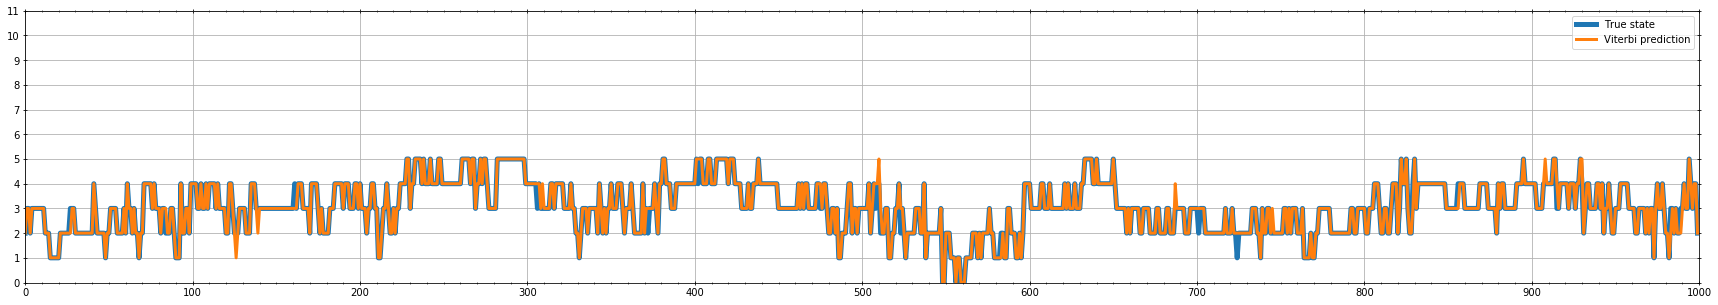

In [13]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,1000,100,10], y_val=[0,11,1,1])

axes.plot(true_state[10000:11000], label="True state", lw=5);
axes.plot(viterbi_state[10000:11000], label="Viterbi prediction", lw=3);
axes.legend();

In [14]:
# print("Accuracy =", accuracy_score(y_pred=viterbi_state, y_true=true_state))
print("F1 macro =", f1_score(y_pred=viterbi_state, y_true=true_state, average='macro'))

F1 macro = 0.9679121104731019


In [15]:
# print("Accuracy =", accuracy_score(y_pred=viterbi_state_test, y_true=true_state_test))
print("F1 macro =", f1_score(y_pred=viterbi_state_test, y_true=true_state_test, average='macro'))

F1 macro = 0.965720329155839


In [16]:
print(viterbi_arr.shape)

(500000, 6)


In [17]:
viterbi_arr_norm = (viterbi_arr - viterbi_arr.min(axis=1).reshape([-1, 1])) / (
    viterbi_arr.max(axis=1).reshape([-1, 1]) -
    viterbi_arr.min(axis=1).reshape([-1, 1]))

print(viterbi_arr_norm.shape)

(500000, 6)


In [18]:
viterbi_arr_test_norm = (viterbi_arr_test - viterbi_arr_test.min(axis=1).reshape([-1, 1])) / (
    viterbi_arr_test.max(axis=1).reshape([-1, 1]) -
    viterbi_arr_test.min(axis=1).reshape([-1, 1]))

print(viterbi_arr_test_norm.shape)

(500000, 6)


In [19]:
# df 
df_viterbi = pd.DataFrame(viterbi_arr_norm)
df_viterbi["signal"] = signal
df_viterbi["shift"] = df_viterbi["signal"].shift(1)
df_viterbi.head()

,0,1,2,3,4,5,signal,shift
0,0.0,0.000000,0.000000,0.000000,0.992932,1.0,2.8555,NaN
1,0.0,0.062926,0.119125,0.160788,0.913743,1.0,3.0907,2.8555
2,0.0,0.098266,0.153245,0.200066,0.232092,1.0,3.5277,3.0907
3,0.0,0.436876,0.472387,0.502629,0.523315,1.0,3.9822,3.5277
4,0.0,0.428564,0.463399,0.493065,0.902112,1.0,3.3368,3.9822


In [20]:
# df test
df_viterbi_test = pd.DataFrame(viterbi_arr_test_norm)
df_viterbi_test["signal"] = signal_test
df_viterbi_test["shift"] = df_viterbi_test["signal"].shift(1)
df_viterbi_test.head()

,0,1,2,3,4,5,signal,shift
0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,3.560969,NaN
1,0.0,0.404783,0.441081,0.471994,0.493139,1.0,3.376637,3.560969
2,0.0,0.433390,0.468618,0.498619,0.519139,1.0,3.857606,3.376637
3,0.0,0.429025,0.463897,0.493596,0.513910,1.0,3.598474,3.857606
4,0.0,0.435325,0.470710,0.500844,0.521457,1.0,3.918743,3.598474


In [21]:
def fe(df):
    for col in range(6):
        df[f"shift_{col}"] = df[col].shift(1)
        
    return df
df_viterbi = fe(df_viterbi)
df_viterbi_test = fe(df_viterbi_test)

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(viterbi_arr_norm, true_state)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [23]:
print("train F1 macro =", f1_score(y_pred=tree.predict(viterbi_arr_norm), y_true=true_state, average='macro'))
print("test F1 macro =", f1_score(y_pred=tree.predict(viterbi_arr_test_norm), y_true=true_state_test, average='macro'))

train F1 macro = 0.9740282610309926
test F1 macro = 0.9636720547663451


4


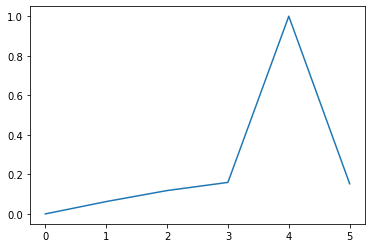

In [24]:
idx = np.random.randint(500000)
plt.plot(viterbi_arr_norm[idx,:])
print(true_state[idx])